In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 50
BATCH_SIZE = 64
PATCH_DIMENSIONS = (128, 128)
DATA_LOCATION = r"D:\data\food"

# Transfer learning 101

In this notebook we will be using the food 101 dataset: https://www.kaggle.com/kmader/food41
We will just load the data in and resize it to 128x128 without looking to much into pre-processing or hyper parameter tuning given it is outside the scope of this session.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(validation_split=0.3, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=15, zoom_range=0.5)
train_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="training")
validation_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="validation")

Found 70700 images belonging to 101 classes.
Found 30300 images belonging to 101 classes.


## Let's have a look at the data we are dealing with

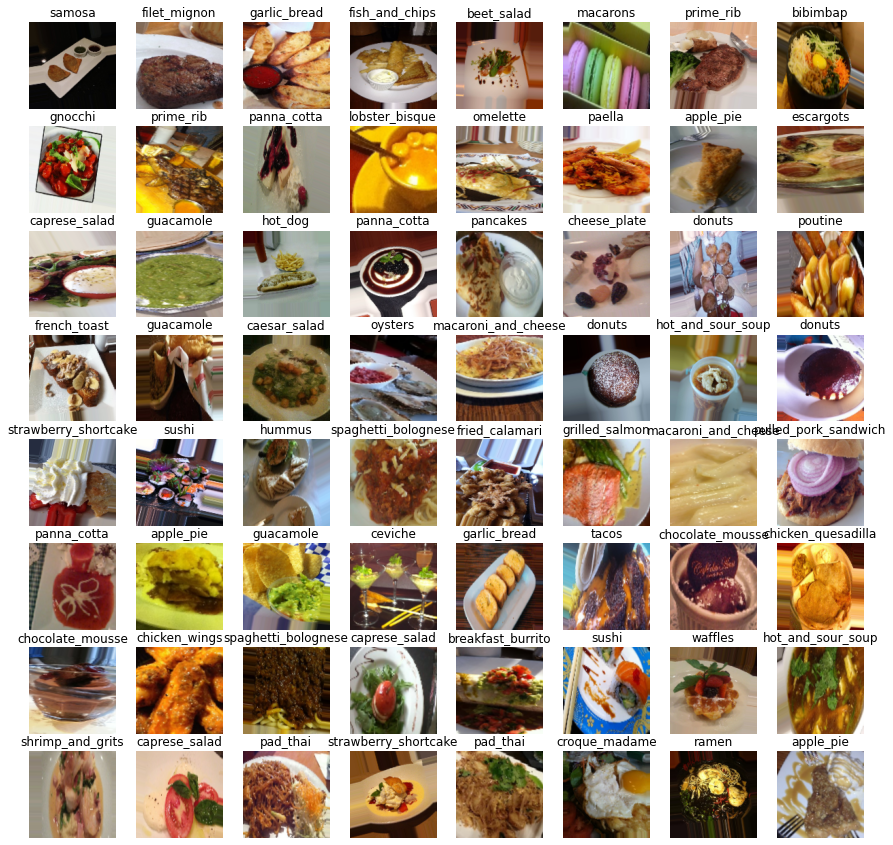

In [3]:
import matplotlib.pyplot as plt
import numpy as np
X, Y = train_generator.__getitem__(0)

classes = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(8, 8,figsize=(15,15))
for x in range(8):
    for y in range(8):
        axes[x][y].imshow((X[x*8 + y]).astype("uint8"))
        class_num = int(np.argmax(Y[x*8 + y]))
        class_name = classes[class_num]
        axes[x][y].title.set_text(class_name)
        axes[x][y].axis('off')

plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale camera's of everyday objects (not just food).

In this notebook we are gone to see what a difference it makes to have 

In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(num_frozen_blocks: int = 0):
    n_classes = len(classes)
    pre_trained_model = EfficientNetB0(include_top=False, weights="imagenet")

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    all_layers = ["stem", "block1", "block2", "block3", "block4", "block5", "block6","block7", "top"]
    layers2freeze = tuple(all_layers[:num_frozen_blocks])
    for layer in model.layers:
        if layer.name.startswith(layers2freeze):
            layer.trainable = False

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model


In [5]:
model_frozen_base = create_model(4)
history = model_frozen_base.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/50
1105/1105 [==============================] - 1729s 2s/step - loss: 2.5063 - accuracy: 0.4045 - val_loss: 1.9173 - val_accuracy: 0.5199
Epoch 2/50
1105/1105 [==============================] - 622s 563ms/step - loss: 1.7764 - accuracy: 0.5455 - val_loss: 1.7302 - val_accuracy: 0.5638
Epoch 3/50
1105/1105 [==============================] - 613s 554ms/step - loss: 1.5861 - accuracy: 0.5877 - val_loss: 1.6968 - val_accuracy: 0.5702
Epoch 4/50
1105/1105 [==============================] - 612s 554ms/step - loss: 1.4755 - accuracy: 0.6151 - val_loss: 1.5616 - val_accuracy: 0.6033
Epoch 5/50
1105/1105 [==============================] - 629s 569ms/step - loss: 1.3815 - accuracy: 0.6339 - val_loss: 1.5461 - val_accuracy: 0.6050
Epoch 6/50
1105/1105 [==============================] - 1502s 1s/step - loss: 1.3108 - accuracy: 0.6508 - val_loss: 1.5109 - val_accuracy: 0.6182
Epoch 7/50
1105/1105 [==============================] - 891s 806ms/step - loss: 1.2384 - accuracy: 0.6674 - val_loss

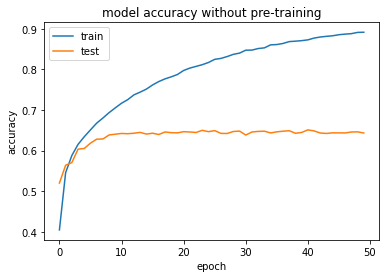

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy without pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

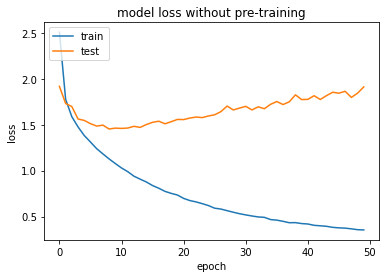

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss without pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
model_very_frozen = create_model(8)
history = model_very_frozen.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/50
1105/1105 [==============================] - 1744s 2s/step - loss: 3.1403 - accuracy: 0.3289 - val_loss: 2.5043 - val_accuracy: 0.4151
Epoch 2/50
1105/1105 [==============================] - 607s 550ms/step - loss: 2.3461 - accuracy: 0.4336 - val_loss: 2.2802 - val_accuracy: 0.4477
Epoch 3/50
1105/1105 [==============================] - 600s 543ms/step - loss: 2.1556 - accuracy: 0.4667 - val_loss: 2.1868 - val_accuracy: 0.4663
Epoch 4/50
1105/1105 [==============================] - 599s 543ms/step - loss: 2.0485 - accuracy: 0.4870 - val_loss: 2.1415 - val_accuracy: 0.4772
Epoch 5/50
1105/1105 [==============================] - 600s 543ms/step - loss: 1.9722 - accuracy: 0.5034 - val_loss: 2.1024 - val_accuracy: 0.4878
Epoch 6/50
1105/1105 [==============================] - 601s 544ms/step - loss: 1.9227 - accuracy: 0.5132 - val_loss: 2.0821 - val_accuracy: 0.4946
Epoch 7/50
1105/1105 [==============================] - 601s 544ms/step - loss: 1.8605 - accuracy: 0.5274 - val_lo

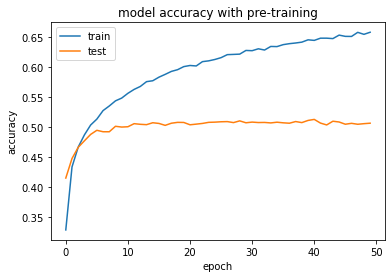

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

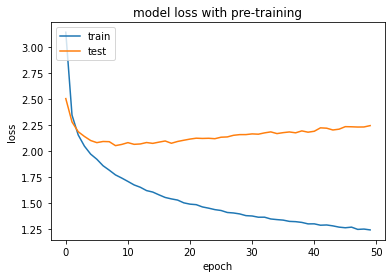

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
model_completely_frozen = create_model(9)
history = model_completely_frozen.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/50
1105/1105 [==============================] - 601s 544ms/step - loss: 3.3103 - accuracy: 0.2969 - val_loss: 2.8201 - val_accuracy: 0.3720
Epoch 2/50
1105/1105 [==============================] - 602s 545ms/step - loss: 2.7502 - accuracy: 0.3815 - val_loss: 2.7240 - val_accuracy: 0.3987
Epoch 3/50
1105/1105 [==============================] - 601s 544ms/step - loss: 2.6349 - accuracy: 0.4076 - val_loss: 2.6767 - val_accuracy: 0.4103
Epoch 4/50
1105/1105 [==============================] - 601s 544ms/step - loss: 2.5777 - accuracy: 0.4176 - val_loss: 2.6696 - val_accuracy: 0.4119
Epoch 5/50
1105/1105 [==============================] - 602s 545ms/step - loss: 2.5354 - accuracy: 0.4268 - val_loss: 2.6519 - val_accuracy: 0.4130
Epoch 6/50
1105/1105 [==============================] - 601s 544ms/step - loss: 2.5084 - accuracy: 0.4288 - val_loss: 2.7390 - val_accuracy: 0.4073
Epoch 7/50
1105/1105 [==============================] - 601s 544ms/step - loss: 2.5052 - accuracy: 0.4316 - val_

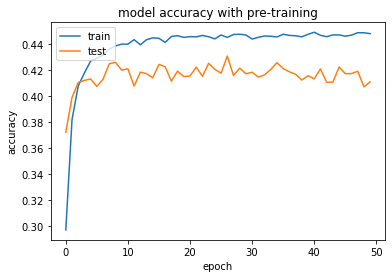

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

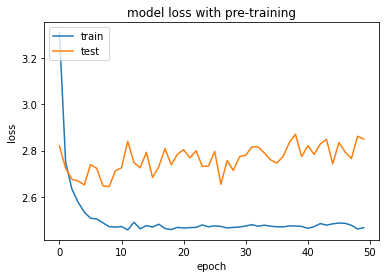

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()